# Creating dataset for Timeseries training

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

In [1]:

import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
# for timezone()
import pytz
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def plot_series(time, series, format="-", start=0, end=None, interval=95):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """
    
    # Setup dimensions of the graph figure
    figure = plt.figure(figsize=(10, 6))
   
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))

    plt.gcf().autofmt_xdate()
    plt.show()

In [3]:

def getStockData(history_span, the_ticker):
  THE_URL = ('https://query1.finance.yahoo.com/v7/finance/'+
           'download/{ticker}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true')
  tdy = datetime.datetime.now(tz=pytz.timezone('Asia/Jakarta'))

  p2 = math.ceil(tdy.timestamp())
  p1 = math.floor((tdy - relativedelta(years=history_span)).timestamp())
  yf_url = THE_URL.format(ticker=the_ticker,period1=p1, period2=p2)
  df = pd.read_csv(yf_url)
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
  return df

In [ ]:
ticker_name = input('input ticker name:')
historical_span = int(input('input historical years:'))



In [18]:
df = getStockData(historical_span, ticker_name)

In [6]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

## Convert to Tensor (Eager Tensor)

In [7]:
df_close = df['Close']
ds_close = tf.convert_to_tensor(df_close)
print(type(ds_close))

<class 'tensorflow.python.framework.ops.EagerTensor'>


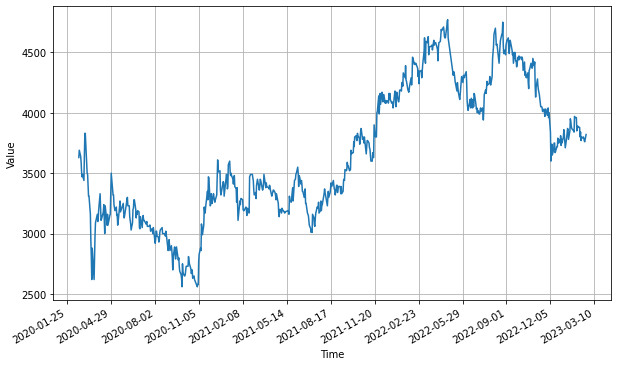

In [8]:
plot_series(df['Date'], ds_close)

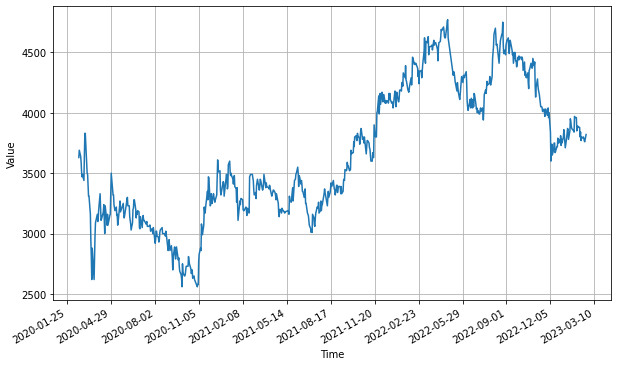

In [9]:
plot_series(df['Date'], df_close)

## Normalize

In [10]:
print(ds_close.shape)
print(df_close.shape)
print(df.shape)

(735,)
(735,)
(735, 7)


In [11]:
df_close = df['Close']
ds_close = tf.convert_to_tensor(df_close)
print(ds_close.shape)
normalizer = tf.keras.layers.Normalization(axis=None)
normalizer.adapt(ds_close)
ds_close_normalized = normalizer(ds_close)
print(type(ds_close_normalized))

(735,)
<class 'tensorflow.python.framework.ops.EagerTensor'>


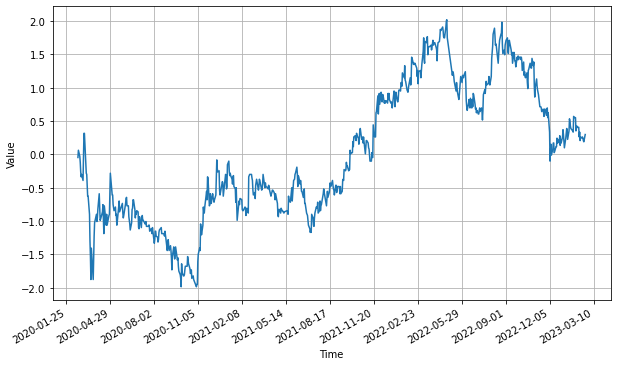

In [12]:
plot_series(df['Date'], ds_close_normalized)

## Dataset Window



### Create dataset Window from Eager tensors

In [13]:
df_close = df['Close']
ds_close = tf.convert_to_tensor(df_close)
print(type(ds_close))

<class 'tensorflow.python.framework.ops.EagerTensor'>


### Create batches for training

Below is standard code for creating windowed dataset

Also, look at this line of code:   

```python
# Create batches of windows
ds_close_windowd = ds_close_windowd.batch(2).prefetch(1)
```

you will want to group your windows into batches. You can do that with the [batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) method as shown below. Simply specify the batch size and it will return a batched dataset with that number of windows. As a rule of thumb, it is also good to specify a [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) step. This optimizes the execution time when the model is already training. By specifying a prefetch `buffer_size` of `1` as shown below, Tensorflow will prepare the next one batch in advance (i.e. putting it in a buffer) while the current batch is being consumed by the model. You can read more about it [here](https://towardsdatascience.com/optimising-your-input-pipeline-performance-with-tf-data-part-1-32e52a30cac4#Prefetching).

In [14]:
df_close = df['Close']
ds_close = tf.convert_to_tensor(df_close)


# Window the data but only take those with the specified size
ds_close = tf.data.Dataset.from_tensor_slices(ds_close)
print(type(ds_close))
print(df['Close'][:10])

ds_close_windowd = ds_close.window(5, shift=1, drop_remainder=True)



# Print the result
ii = 0
print('Windowed:')
print(type(ds_close_windowd))
for window_dataset in ds_close_windowd:
  print([item.numpy() for item in window_dataset])
  if(ii>5):
    break
  ii = ii+1

# Flatten the windows by putting its elements in a single batch
ds_close_windowd = ds_close_windowd.flat_map(lambda window: window.batch(5))


ii = 0
print()
print('Flat mapped:')
print(type(ds_close_windowd))
for window_dataset in ds_close_windowd:
  print([item.numpy() for item in window_dataset])
  if(ii>5):
    break
  ii = ii+1

# Create tuples with features (first four elements of the window) and labels (last element)
ds_close_windowd = ds_close_windowd.map(lambda window: (window[:-1], window[-1]))

ii = 0
print()
print('Labelled:')
print(type(ds_close_windowd))
for window_dataset in ds_close_windowd:
  print([item.numpy() for item in window_dataset])
  if(ii>5):
    break
  ii = ii+1

# Shuffle the windows
ds_close_windowd = ds_close_windowd.shuffle(buffer_size=10)

# Print the results
print()
print('Shuffled:')
print(type(ds_close_windowd))
ii = 0
for x,y in ds_close_windowd:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()
  if(ii>4):
    break
  ii = ii+1 

# Create batches of windows
ds_close_windowd = ds_close_windowd.batch(2).prefetch(1)

# Print the results
ii = 0
print()
print('batched:')
print(type(ds_close_windowd))
for x,y in ds_close_windowd:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()
  if(ii>4):
    break
  ii = ii+1  


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<class 'tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset'>
0    3630.0
1    3690.0
2    3640.0
3    3590.0
4    3510.0
5    3470.0
6    3490.0
7    3440.0
8    3620.0
9    3830.0
Name: Close, dtype: float64
Windowed:
<class 'tensorflow.python.data.ops.dataset_ops.WindowDataset'>
[3630.0, 3690.0, 3640.0, 3590.0, 3510.0]
[3690.0, 3640.0, 3590.0, 3510.0, 3470.0]
[3640.0, 3590.0, 3510.0, 3470.0, 3490.0]
[3590.0, 3510.0, 3470.0, 3490.0, 3440.0]
[3510.0, 3470.0, 3490.0, 3440.0, 3620.0]
[3470.0, 3490.0, 3440.0, 3620.0, 3830.0]
[3490.0, 3440.0, 3620.0, 3830.0, 3830.0]

Flat mapped:
<class 'tensorflow.python.data.ops.dataset_ops.FlatMapDataset'>
[3630.0, 3690.0, 3640.0, 3590.0, 3510.0]
[3690.0, 3640.0, 3590.0, 3510.0, 3470.0]
[3640.0, 3590.0, 3510.0, 3470.0, 3490.0]
[3590.0, 3510.0, 3470.0, 3490.0, 3440.0]
[3510.0, 3470.0, 3490.0, 3440.0, 3620.0]
[3470.0, 3490.0, 3440.0, 3620.0, 3830.0]
[3490.0, 3440.0, 3620.0, 3830.0, 3830.0]

Labelled:
<class 'tensorflow.python.data.ops.dat

### Create dataset window from pandas Series

In [15]:
print(type(df[['Close']]))
print(type(df['Close']))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [16]:
df['Close'].head()

0    3630.0
1    3690.0
2    3640.0
3    3590.0
4    3510.0
Name: Close, dtype: float64

In [17]:
# Window the data but only take those with the specified size
ds_close = tf.data.Dataset.from_tensor_slices((df['Close']))
print(type(ds_close))
print(df['Close'][:10])

ds_close_windowd = ds_close.window(5, shift=1, drop_remainder=True)


# Print the result
ii = 0
print('Windowed:')
print(type(ds_close_windowd))
for window_dataset in ds_close_windowd:
  print([item.numpy() for item in window_dataset])
  if(ii>5):
    break
  ii = ii+1

# Flatten the windows by putting its elements in a single batch
ds_close_windowd = ds_close_windowd.flat_map(lambda window: window.batch(5))


ii = 0
print()
print('Flat mapped:')
print(type(ds_close_windowd))
for window_dataset in ds_close_windowd:
  print([item.numpy() for item in window_dataset])
  if(ii>5):
    break
  ii = ii+1

# Create tuples with features (first four elements of the window) and labels (last element)
ds_close_windowd = ds_close_windowd.map(lambda window: (window[:-1], window[-1]))

ii = 0
print()
print('Labelled:')
print(type(ds_close_windowd))
for window_dataset in ds_close_windowd:
  print([item.numpy() for item in window_dataset])
  if(ii>5):
    break
  ii = ii+1

# Shuffle the windows
ds_close_windowd = ds_close_windowd.shuffle(buffer_size=10)

# Print the results
print()
print('Shuffled:')
print(type(ds_close_windowd))
ii = 0
for x,y in ds_close_windowd:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()
  if(ii>4):
    break
  ii = ii+1 

# Create batches of windows
ds_close_windowd = ds_close_windowd.batch(2).prefetch(1)

# Print the results
ii = 0
print()
print('batched:')
print(type(ds_close_windowd))
for x,y in ds_close_windowd:
  print("x = ", x.numpy())
  print("y = ", y.numpy())
  print()
  if(ii>4):
    break
  ii = ii+1  


<class 'tensorflow.python.data.ops.from_tensor_slices_op.TensorSliceDataset'>
0    3630.0
1    3690.0
2    3640.0
3    3590.0
4    3510.0
5    3470.0
6    3490.0
7    3440.0
8    3620.0
9    3830.0
Name: Close, dtype: float64
Windowed:
<class 'tensorflow.python.data.ops.dataset_ops.WindowDataset'>
[3630.0, 3690.0, 3640.0, 3590.0, 3510.0]
[3690.0, 3640.0, 3590.0, 3510.0, 3470.0]
[3640.0, 3590.0, 3510.0, 3470.0, 3490.0]
[3590.0, 3510.0, 3470.0, 3490.0, 3440.0]
[3510.0, 3470.0, 3490.0, 3440.0, 3620.0]
[3470.0, 3490.0, 3440.0, 3620.0, 3830.0]
[3490.0, 3440.0, 3620.0, 3830.0, 3830.0]

Flat mapped:
<class 'tensorflow.python.data.ops.dataset_ops.FlatMapDataset'>
[3630.0, 3690.0, 3640.0, 3590.0, 3510.0]
[3690.0, 3640.0, 3590.0, 3510.0, 3470.0]
[3640.0, 3590.0, 3510.0, 3470.0, 3490.0]
[3590.0, 3510.0, 3470.0, 3490.0, 3440.0]
[3510.0, 3470.0, 3490.0, 3440.0, 3620.0]
[3470.0, 3490.0, 3440.0, 3620.0, 3830.0]
[3490.0, 3440.0, 3620.0, 3830.0, 3830.0]

Labelled:
<class 'tensorflow.python.data.ops.dat